# Проект

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

- В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
- Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
- Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Импорт библиотек

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from operator import attrgetter

Загрузка данных

In [4]:
reg_data = pd.read_csv("~/shared/problem1-reg_data.csv", sep=";")
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
auth_data = pd.read_csv("~/shared/problem1-auth_data.csv", sep=";")
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Предварительная проверка данных

In [6]:
# преобразование временных меток в даты
reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit='s')
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [7]:
# преобразование временных меток в даты
auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s')
auth_data.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [8]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


In [9]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


In [10]:
reg_data.shape

(1000000, 2)

In [11]:
auth_data.shape

(9601013, 2)

In [12]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [13]:
auth_data.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

Объединим данные

In [14]:
df = reg_data.merge(auth_data, on='uid')
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


Посмотрим на разброс дат, чтобы рассчитать retention

In [15]:
df[['reg_ts','auth_ts']].max()

reg_ts    2020-09-23 15:17:24
auth_ts   2020-09-23 15:17:24
dtype: datetime64[ns]

In [16]:
df[['reg_ts','auth_ts']].min()

reg_ts    1998-11-18 09:43:43
auth_ts   1998-11-18 09:43:43
dtype: datetime64[ns]

Поскольку временной интервал слишком большой, то можно проанализировать Retention за месячный период.

Расчет Retention

In [22]:
def cohort_retention(period, frame, reg_date, auth_date, cus_id):
    data = frame.query('reg_ts >= @period').copy()
    
    data[reg_date] = pd.to_datetime(data[reg_date]).dt.to_period("d")
    data[auth_date] = pd.to_datetime(data[auth_date]).dt.to_period("d")
    data['days'] = (data[auth_date] - data[reg_date]).apply(attrgetter('n'))
    
    cohort = data.pivot_table(index = reg_date, columns='days', values = 'uid', aggfunc = 'nunique')
    cohort = cohort.div(cohort.iloc[:,0], axis = 0)

    final_table = (cohort
            .style
            .background_gradient(cmap='viridis')
            .format("{:.2%}", na_rep="")
            .set_caption("Retention"))

    return final_table

In [23]:
cohort_retention(period="2020-08-23", frame=df, reg_date='reg_ts', auth_date='auth_ts', cus_id='uid')

days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
reg_ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-23,100.00%,2.50%,3.84%,4.87%,4.93%,6.98%,8.19%,5.70%,5.12%,4.55%,6.72%,4.99%,6.02%,4.42%,6.27%,4.74%,4.99%,4.61%,4.67%,3.39%,4.74%,3.97%,4.42%,3.39%,3.91%,3.14%,3.65%,4.16%,2.88%,3.07%,3.39%,1.79%
2020-08-24,100.00%,1.79%,4.15%,4.28%,5.11%,5.75%,7.60%,6.01%,4.92%,5.18%,5.18%,4.79%,6.01%,5.56%,4.54%,5.11%,4.35%,4.66%,4.09%,5.11%,3.96%,3.51%,3.64%,3.45%,4.47%,3.13%,3.26%,3.13%,3.13%,2.81%,1.28%,
2020-08-25,100.00%,1.98%,4.40%,4.79%,5.68%,5.30%,5.30%,6.25%,3.70%,5.74%,4.72%,5.04%,4.21%,4.79%,4.34%,4.85%,4.28%,4.08%,3.77%,4.34%,3.64%,3.51%,3.57%,3.25%,3.25%,4.40%,2.81%,3.13%,3.19%,2.30%,,
2020-08-26,100.00%,1.46%,3.44%,4.20%,4.52%,6.43%,6.56%,5.99%,4.59%,4.33%,4.08%,5.92%,4.78%,4.39%,4.78%,3.31%,3.95%,4.14%,4.01%,3.95%,3.76%,2.61%,4.27%,3.25%,2.74%,2.93%,2.80%,2.74%,1.66%,,,
2020-08-27,100.00%,1.65%,3.37%,4.77%,5.21%,5.53%,6.17%,5.72%,4.32%,5.40%,5.40%,5.28%,4.45%,5.15%,4.20%,4.58%,4.26%,4.58%,3.62%,3.62%,3.56%,4.64%,2.99%,2.99%,3.88%,3.37%,2.73%,1.46%,,,,
2020-08-28,100.00%,2.03%,4.57%,5.27%,4.76%,6.29%,6.22%,5.46%,5.59%,5.27%,4.83%,4.63%,5.40%,4.38%,4.89%,4.51%,4.95%,5.27%,4.44%,4.25%,4.13%,4.38%,4.70%,4.06%,2.86%,3.68%,2.54%,,,,,
2020-08-29,100.00%,2.53%,3.74%,4.63%,5.70%,5.51%,6.97%,5.70%,4.56%,6.02%,4.31%,4.56%,6.65%,4.75%,5.39%,4.75%,4.56%,4.50%,3.80%,4.44%,3.42%,4.44%,4.25%,3.49%,3.55%,1.71%,,,,,,
2020-08-30,100.00%,1.84%,3.48%,3.92%,5.38%,5.95%,6.58%,5.57%,4.30%,4.30%,5.19%,4.81%,5.13%,4.56%,4.11%,4.37%,3.29%,4.30%,4.49%,3.67%,3.86%,3.61%,4.05%,3.73%,1.77%,,,,,,,
2020-08-31,100.00%,1.83%,3.66%,4.23%,5.12%,6.89%,6.51%,6.70%,4.80%,5.37%,5.05%,5.31%,4.86%,4.42%,3.85%,5.18%,4.74%,3.66%,3.79%,4.55%,3.47%,3.98%,2.78%,1.90%,,,,,,,,


# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [110]:
# загрузка данных
df_2 = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')
df_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [111]:
# проверка структуры данных
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [112]:
# проверка размера данных
df_2.shape

(404770, 3)

In [113]:
# проверка количества уникальных пользователей
df_2.user_id.nunique()

404770

In [114]:
# проверка наличия пропущеных значений
df_2.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [115]:
# проверка наличия дупликатов
df_2.duplicated().sum()

0

**Основные метрики, которые стоит проанализировать для принятия правильного решения:**
- ARPU (Average Revenue Per User) — это средняя выручка на одного пользователя. Он показывает, сколько денег в среднем приносит компании один пользователь за определённый промежуток времени.
- ARPPU (Average Revenue Per Paying User) очень похож на ARPU — это тоже средний доход, но только от платящих пользователей. Это показатель, который учитывает только тех, кто произвёл покупку или совершил платёж.
- CR (conversion rate, коэффициент конверсии) — процент пользователей, которые совершили целевое действие — например, купили товар или подписались на рассылку.

Анализ данных

In [116]:
# опишем данные
df_2.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [117]:
# опишем данные группы А
df_2.query('testgroup == "a"').revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [118]:
# опишем данные группы В
df_2.query('testgroup == "b"').revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [119]:
# Медианное значение платящих пользователей для групп a и b
print(f'''a: {df_2.query('testgroup == "a" & revenue > 0').revenue.median()}, b: {df_2.query('testgroup == "b" & revenue > 0').revenue.median()}''')

a: 311.0, b: 3022.0


In [120]:
arpu_a = df_2.query('testgroup == "a"').revenue.mean()
arpu_b = df_2.query('testgroup == "b"').revenue.mean()

In [121]:
arppu_a = df_2.query('testgroup == "a" & revenue > 0').revenue.mean()
arppu_b = df_2.query('testgroup == "b" & revenue > 0').revenue.mean()

In [122]:
cr_a = ((df_2.query('testgroup == "a" & revenue > 0').user_id.count() / df_2.query('testgroup == "a"').user_id.count()) * 100).round(2)
cr_b = ((df_2.query('testgroup == "b" & revenue > 0').user_id.count() / df_2.query('testgroup == "b"').user_id.count()) * 100).round(2)

In [123]:
metrics = pd.DataFrame({
    'ARPU': [arpu_a, arpu_b],
    'ARPPU': [arppu_a, arppu_b],
    'CR': [cr_a, cr_b],
})
metrics = metrics.rename(index = {0: 'a_group', 1: 'b_group'})
metrics

,ARPU,ARPPU,CR
a_group,25.413720,2663.998444,0.95
b_group,26.751287,3003.658172,0.89


- ARPU в группе А ниже на 5%, чем в группе В, что указывает на большую монетизацию.
- ARPPU в группе А ниже на 11%, чем в группе В, что указывает на то, что те, кто платит, тратят больше денег в группе А.
- Конверсия в платящих пользователей в группе А выше на 0.06, что может быть связано с тем, что предложение привлекает меньше пользователей.

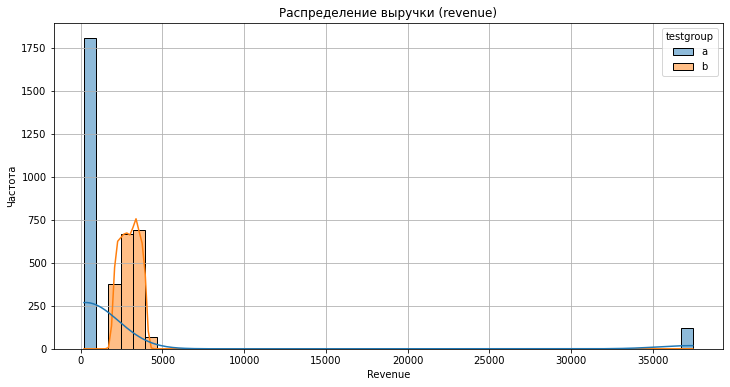

In [124]:
# Гистограмма
plt.figure(figsize=(12, 6))
sns.histplot(df_2[df_2['revenue'] > 0], x='revenue', hue='testgroup', bins=50, kde=True)
plt.title('Распределение выручки (revenue)')
plt.xlabel('Revenue')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

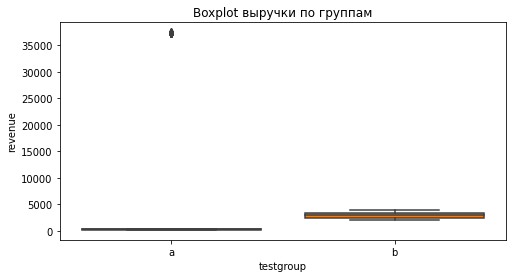

In [125]:
# Boxplot по группам
plt.figure(figsize=(8, 4))
sns.boxplot(x='testgroup', y='revenue', data = df_2[df_2['revenue'] > 0])
plt.title('Boxplot выручки по группам')
plt.show()

Теперь нужно проверить, имеем ли мы дело со статистически значимыми различиями.

Чтобы сравнить показатели конверсии, я применю **Z-тест**. Этот метод позволяет оценить различия в долях (конверсиях) между группами.


- H0: Конверсия в обеих группах одинакова.
- P-value < 0.05 — нулевая гипотеза отвергается.

In [126]:
from statsmodels.stats.proportion import proportions_ztest

groups = df_2.groupby('testgroup')
total_users = groups.size()
paying_users = groups.apply(lambda x: (x['revenue'] > 0).sum())

In [127]:
stat, pval = proportions_ztest([paying_users['a'], paying_users['b']], [total_users['a'], total_users['b']])

print(f'p-value = {pval:.3f}')
if pval < 0.05:
    print('Конверсия отличается статистически значимо.')
else:
    print('Нет статистически значимой разницы в конверсии.')

p-value = 0.035
Конверсия отличается статистически значимо.


**ARPU и ARPPU**

Используем T-test.
- Дисперсии не различаются, и сравниваются средние.
- Размер и разброс значений в группах примерно одинаковы.
- Выборка достаточно большая (более 30 наблюдений).


Условия для T-test:
- Н0: Есть статистически значимая разница между группами А и В.
- P-value < 0.05 — нулевая гипотеза отвергается.

In [128]:
# ARPU

t_stat, pval_t = ss.ttest_ind(df_2.query('testgroup == "a"')['revenue'], df_2.query('testgroup == "b"')['revenue'])

print(f'p-value = {pval_t:.3f}')
if pval_t < 0.05:
    print("Средние значения ARPU различаются статистически значимо.")
else:
    print("Нет статистически значимой разницы в ARPU.")

p-value = 0.532
Нет статистически значимой разницы в ARPU.


In [129]:
# ARPPU

t_stat_arppu, pval_arppu = ss.ttest_ind(df_2.query('testgroup == "a" & revenue > 0')['revenue'], df_2.query('testgroup == "b" & revenue > 0')['revenue'])

print(f'p-value = {pval_arppu:.3f}')
if pval_arppu < 0.05:
    print("Средние значения ARPPU различаются статистически значимо.")
else:
    print("Нет статистически значимой разницы в ARPPU.")

p-value = 0.112
Нет статистически значимой разницы в ARPPU.


Необходимо проверить статистическую значимость в **CR**.

Используем тест на независимость Хи-квадрат.

Нулевая гипотеза предполагает, что разница между средними значениями показателя в сегментах незначительна.

In [130]:
df_2['purchase'] = df_2['revenue'].apply(lambda x: 'purchase' if x != 0 else 'no_purchase')

for_chi2 = pd.crosstab(df_2['testgroup'], df_2['purchase'])

chi2_result = ss.chi2_contingency(for_chi2)

chi2_result

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

Отвергаем нулевую гипотезу. Есть статистически значимые различия, так как P-value < 0.05 (P-value = 0.036)

**Выводы**

Несмотря на потенциально более высокую выручку от отдельных платящих пользователей в группе B, снижение конверсии в оплату является статистически значимым и может негативно сказаться на общем доходе в будущем. Так как рост ARPU и ARPPU не подтвержден статистически, а снижение конверсии — подтверждено, нет оснований утверждать, что изменение в предложении (группа B) дает устойчивый положительный эффект.

В текущих условиях группа A показывает более стабильные и надежные результаты. Можно запустить повторный A/B тест на большей выборке и добавить метрики повторных покупок, LTV, retention. Возможно, вариант B хорошо работает для определенных групп.

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Базовые метрики:**

- DAU, WAU, MAU - это метрики, которые показывают активность пользователей цифрового продукта за разные периоды (день, неделя, месяц).
- Retention (удержание) — это метрика, которая показывает, сколько пользователей продолжают использовать продукт или сервис после первого взаимодействия с ним.
- Среднее количество пройденных уровней.
- Среднее время прохождения уровней.
- Средняя продолжительность игровой сессии.
- Монетизация.
- Отзывы и рейтинги.

**Если добавить механику отката уровней:**

- Среднее количество откатов.
- Сколько раз игроки переигрывают один и тот же уровень.
- Среднее время прохождения уровня.
- А также вышеупомянутые базовые метрики.